# Simple recurrent SLDS on eigen-worm time series

In [1]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

In [2]:
#data loadinf
from scipy.io import loadmat
import h5py

In [3]:
file = '/tigress/LEIFER/Kevin/20180831/Data20180831_123355/analysis/ProjectedEigenValues.mat'
f = h5py.File(file,'r')

In [6]:
trac_num = 10
y = f[f['values'][trac_num][0]].value

/usr/licensed/anaconda3/2019.3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


(8015, 19)

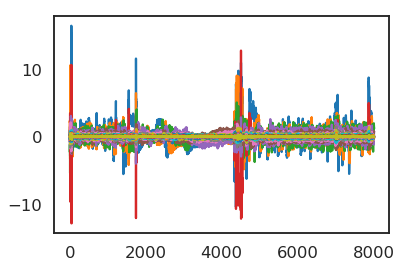

In [7]:
plt.plot(y);
y.shape

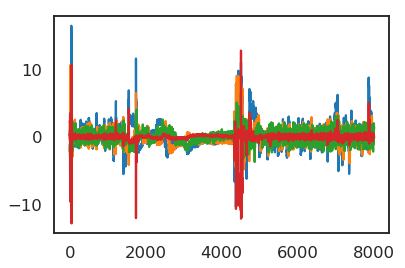

In [8]:
#plt.imshow(y[:,:4].T,aspect='auto')
plt.plot(y[:,:4])

In [9]:
# Global parameters
T = y.shape[0]
K = 3
D_obs = y.shape[1]
D_latent = 2

In [3]:
# # Simulate the "nascar" data
# def make_nascar_model():
#     As = [random_rotation(D_latent, np.pi/24.),
#       random_rotation(D_latent, np.pi/48.)]

#     # Set the center points for each system
#     centers = [np.array([+2.0, 0.]),
#            np.array([-2.0, 0.])]
#     bs = [-(A - np.eye(D_latent)).dot(center) for A, center in zip(As, centers)]

#     # Add a "right" state
#     As.append(np.eye(D_latent))
#     bs.append(np.array([+0.1, 0.]))

#     # Add a "right" state
#     As.append(np.eye(D_latent))
#     bs.append(np.array([-0.25, 0.]))

#     # Construct multinomial regression to divvy up the space
#     w1, b1 = np.array([+1.0, 0.0]), np.array([-2.0])   # x + b > 0 -> x > -b
#     w2, b2 = np.array([-1.0, 0.0]), np.array([-2.0])   # -x + b > 0 -> x < b
#     w3, b3 = np.array([0.0, +1.0]), np.array([0.0])    # y > 0
#     w4, b4 = np.array([0.0, -1.0]), np.array([0.0])    # y < 0
#     Rs = np.row_stack((100*w1, 100*w2, 10*w3,10*w4))
#     r = np.concatenate((100*b1, 100*b2, 10*b3, 10*b4))
    
#     true_rslds = ssm.SLDS(D_obs, K, D_latent, 
#                       transitions="recurrent_only",
#                       dynamics="diagonal_gaussian",
#                       emissions="gaussian_orthog",
#                       single_subspace=True)
#     true_rslds.dynamics.mu_init = np.tile(np.array([[0, 1]]), (K, 1))
#     true_rslds.dynamics.sigmasq_init = 1e-4 * np.ones((K, D_latent))
#     true_rslds.dynamics.As = np.array(As)
#     true_rslds.dynamics.bs = np.array(bs)
#     true_rslds.dynamics.sigmasq = 1e-4 * np.ones((K, D_latent))
    
#     true_rslds.transitions.Rs = Rs
#     true_rslds.transitions.r = r
    
#     true_rslds.emissions.inv_etas = np.log(1e-2) * np.ones((1, D_obs))
#     return true_rslds

# # Sample from the model
# true_rslds = make_nascar_model()
# z, x, y = true_rslds.sample(T=T)

In [10]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(y)
q_elbos_lem, q_lem = rslds.fit(y, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0]
#rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, y)))
zhat_lem = rslds.most_likely_states(xhat_lem, y)


Initializing with an ARHMM using 25 steps of EM.


/home/kschen/.local/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/kschen/.local/lib/python3.7/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/kschen/.local/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the fut

In [11]:
# store rslds
zhat_lem = rslds.most_likely_states(xhat_lem, y)
rslds_lem = copy.deepcopy(rslds)

In [12]:
# Fit an rSLDS with its default initialization, using BBVI with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(y)

q_elbos_svi, q_svi = rslds.fit(y, method="bbvi",
                               variational_posterior="tridiag",
                               initialize=False, num_iters=1000)

# Get the posterior mean of the continuous states
xhat_svi = q_svi.mean[0]

# Find the permutation that matches the true and inferred states
# rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_svi, y)))
# zhat_svi = rslds.most_likely_states(xhat_svi, y)

Initializing with an ARHMM using 25 steps of EM.


/home/kschen/.local/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/kschen/.local/lib/python3.7/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/kschen/.local/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the fut

Text(0, 0.5, 'ELBO')

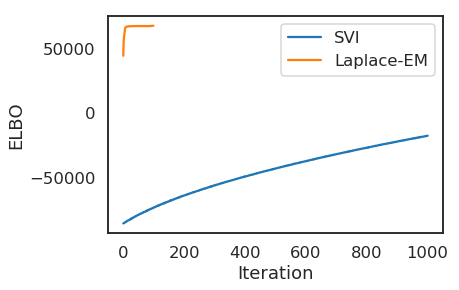

In [13]:
# Plot some results
plt.figure()
plt.plot(q_elbos_svi, label="SVI")
plt.plot(q_elbos_lem[1:], label="Laplace-EM")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("ELBO")

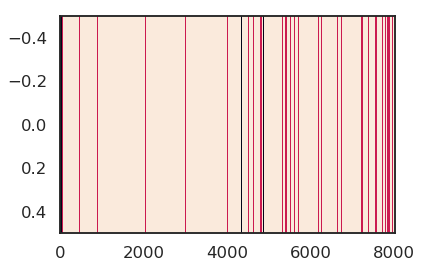

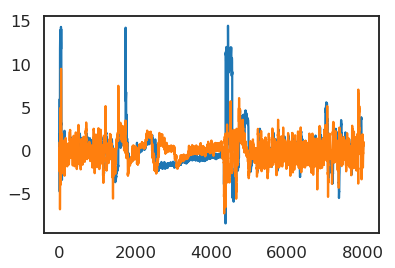

In [14]:
plt.imshow(zhat_lem[None,:],aspect='auto')
plt.figure()
plt.plot(xhat_lem)

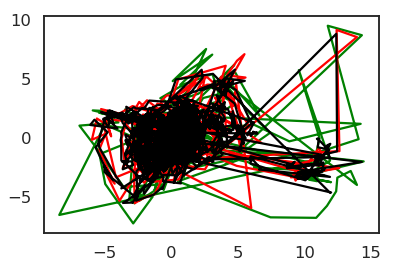

In [15]:
plt.plot(xhat_lem[np.where(zhat_lem==0)[0],0],xhat_lem[np.where(zhat_lem==0)[0],1],'g')
plt.plot(xhat_lem[np.where(zhat_lem==1)[0],0],xhat_lem[np.where(zhat_lem==1)[0],1],'r')
plt.plot(xhat_lem[np.where(zhat_lem==2)[0],0],xhat_lem[np.where(zhat_lem==2)[0],1],'k')

In [16]:
file2 = '/tigress/LEIFER/Kevin/20180831/Data20180831_123355/analysis/Behaviors.mat'
f2 = h5py.File(file2,'r')

In [20]:
beh = f2[f2['values'][trac_num][0]].value

/usr/licensed/anaconda3/2019.3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


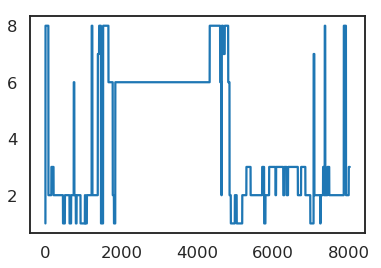

In [21]:
eth = np.zeros(beh.shape[0])
states = np.array([st*beh[:,st] for st in range(0,beh.shape[1])])  #multiply transition by state number
states = np.sum(states,axis=0)  #sum of unique states
states[0] = 1  #initial state
trans = np.where(states>0)[0]
for tt in range(0,len(eth)):
    temp = trans-tt
    temp[temp>0] = -len(eth)
    eth[tt] = states[np.max(temp)+tt]

plt.plot(eth)

In [22]:
def trans2ethogram(beh):
    """
    discrete transitions into states transformed as ethogram
    """
    eth = np.zeros(beh.shape[0])
    states = np.array([st*beh[:,st] for st in range(0,beh.shape[1])])  #multiply transition by state number
    states = np.sum(states,axis=0)  #sum of unique states
    states[0] = 1  #initial state
    trans = np.where(states>0)[0]
    for tt in range(0,len(eth)):
        temp = trans-tt
        temp[temp>0] = -len(eth)
        eth[tt] = states[np.max(temp)+tt]
    return eth

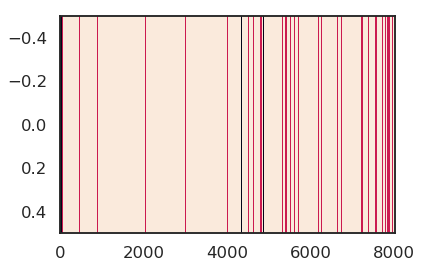

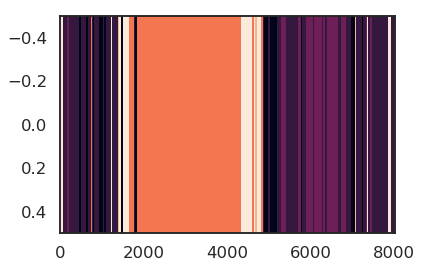

In [23]:
plt.imshow(zhat_lem[None,:],aspect='auto')
plt.figure()
plt.imshow(trans2ethogram(beh)[None,:],aspect='auto')

In [24]:
###not working ethogram method
# eth = np.zeros(beh.shape[0])
# for tt in range(0,len(eth)): ##across time
#     tempb = beh[:tt,:]
#     closest = np.zeros(beh.shape[1])
#     for bb in range(0,beh.shape[1]):  #across behabviors
#         #tempb2 = np.where(tempb[:,bb]==1)[0]
#         acs = np.concatenate([list(np.where(tempb[:,bb]==1)[0]),[-len(eth)]])-tt
#         acs[acs>0] = -len(eth)
#         closest[bb] = np.max(acs)
#     eth[tt] = np.argmin(closest)

/usr/licensed/anaconda3/2019.3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


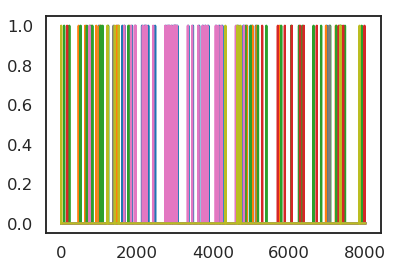

In [25]:
beh = f2[f2['values'][trac_num][0]].value
plt.plot(beh)

In [26]:
# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)

    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

NameError: name 'z' is not defined

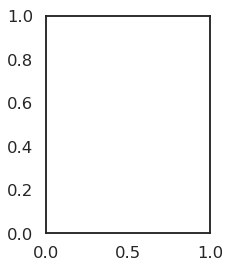

In [27]:
plt.figure(figsize=[10,4])
ax1 = plt.subplot(131)
plot_trajectory(z, x, ax=ax1)
plt.title("True")
ax2 = plt.subplot(132)
plot_trajectory(zhat_svi, xhat_svi, ax=ax2)
plt.title("Inferred, SVI")
ax3 = plt.subplot(133)
plot_trajectory(zhat_lem, xhat_lem, ax=ax3)
plt.title("Inferred, Laplace-EM")
plt.tight_layout()

Text(0.5,1,'Inferred Dynamics, SVI')

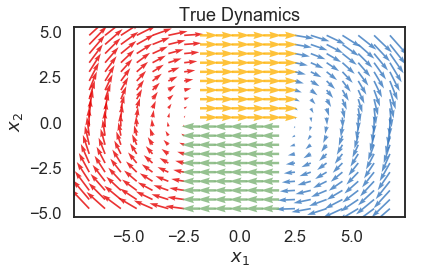

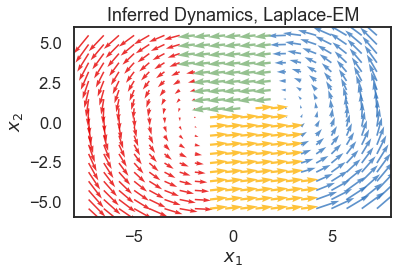

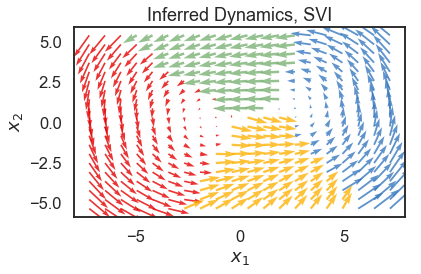

In [11]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(x).max(axis=0) + 1
plot_most_likely_dynamics(true_rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("True Dynamics")

plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, Laplace-EM")

plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_svi).max(axis=0) + 1
plot_most_likely_dynamics(rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, SVI")